In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installments

In [ ]:
!pip install kaggle
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np

#Visual
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot') # Set the style to 'ggplot' instead of 'default'


#Modeling
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator #to resize the image

from tensorflow.keras import optimizers

from sklearn.metrics import classification_report, confusion_matrix


# Importing the data

## Kaggle dataload

Loading the data from Kaggle

- API token from Kaggle, needed

In [ ]:
import os
import zipfile
from google.colab import files

# Path to the Kaggle directory and JSON file
kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')

# Check if the kaggle.json file exists
if not os.path.exists(kaggle_json_path):
  print("Upload your kaggle.json file.")
  files.upload()

  # Create Kaggle directory if it doesn't exist
  os.makedirs(kaggle_dir, exist_ok=True)
  os.system('cp kaggle.json ~/.kaggle/')
  os.system('chmod 600 ~/.kaggle/kaggle.json')

# Path to the ZIP file
zip_file_path = '100-bird-species.zip'

# Check if the ZIP file already exists
if not os.path.exists(zip_file_path):
  # Download the dataset
  os.system('kaggle datasets download -d gpiosenka/100-bird-species')

  # Extract the dataset
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()
else:
  print("ZIP file already exists.")

# Path to the expected birds.csv file within the dataset
birds_csv_path = 'birds.csv'

# Check if the dataset needs to be downloaded and extracted
if not os.path.exists(zip_file_path) or not os.path.exists(birds_csv_path):
  # Download the dataset if the ZIP file is not present
  if not os.path.exists(zip_file_path):
    os.system('kaggle datasets download -d gpiosenka/100-bird-species')
    # Extract the dataset
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall()
else:
  print("Dataset already extracted.")

Upload your kaggle.json file.


Saving kaggle.json to kaggle.json
Dataset already extracted.


## Train, valid, test split

Saving the path and the respective label, on a dataframe for

- train

- valid

- test

In [ ]:
#For delving into the paths
from pathlib import Path

In [ ]:
######################### TRAIN #########################
train_path = '/content/train'

train_dir = Path(train_path)

filepaths = list(train_dir.glob(r'**/*.JPG')) + list(train_dir.glob(r'**/*.jpg')) + list(train_dir.glob(r'**/*.png')) + list(train_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='filepaths', dtype=str)
labels = pd.Series(labels, name='labels', dtype=str)

train_df = pd.concat([filepaths, labels], axis=1)

# Group by 'labels' and randomly select 30 images for each class
reduced_train_df = train_df.groupby('labels', group_keys=True).apply(lambda x: x.sample(n=30, random_state=1)).reset_index(drop=True)


In [ ]:
train_df.shape

(84635, 2)

In [ ]:
reduced_train_df

,filepaths,labels
0,/content/train/ABBOTTS BABBLER/140.jpg,ABBOTTS BABBLER
1,/content/train/ABBOTTS BABBLER/107.jpg,ABBOTTS BABBLER
2,/content/train/ABBOTTS BABBLER/052.jpg,ABBOTTS BABBLER
3,/content/train/ABBOTTS BABBLER/095.jpg,ABBOTTS BABBLER
4,/content/train/ABBOTTS BABBLER/065.jpg,ABBOTTS BABBLER
...,...,...
15745,/content/train/ZEBRA DOVE/36.jpg,ZEBRA DOVE
15746,/content/train/ZEBRA DOVE/170.jpg,ZEBRA DOVE
15747,/content/train/ZEBRA DOVE/55.jpg,ZEBRA DOVE
15748,/content/train/ZEBRA DOVE/124.jpg,ZEBRA DOVE


In [ ]:
reduced_train_df.labels.value_counts()

ABBOTTS BABBLER             30
NORTHERN MOCKINGBIRD        30
NORTHERN GOSHAWK            30
NORTHERN GANNET             30
NORTHERN FULMAR             30
                            ..
CRESTED COUA                30
CRESTED CARACARA            30
CRESTED AUKLET              30
CREAM COLORED WOODPECKER    30
ZEBRA DOVE                  30
Name: labels, Length: 525, dtype: int64

In [ ]:
######################### VALIDATION #########################

val_path = '/content/valid'

val_dir = Path(val_path)

filepaths = list(val_dir.glob(r'**/*.JPG')) + list(val_dir.glob(r'**/*.jpg')) + list(val_dir.glob(r'**/*.png')) + list(val_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='filepaths', dtype=str)
labels = pd.Series(labels, name='labels', dtype=str)

valid_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
valid_df.head()

,filepaths,labels
0,/content/valid/CINNAMON ATTILA/5.jpg,CINNAMON ATTILA
1,/content/valid/CINNAMON ATTILA/4.jpg,CINNAMON ATTILA
2,/content/valid/CINNAMON ATTILA/2.jpg,CINNAMON ATTILA
3,/content/valid/CINNAMON ATTILA/1.jpg,CINNAMON ATTILA
4,/content/valid/CINNAMON ATTILA/3.jpg,CINNAMON ATTILA


In [ ]:
valid_df.shape

(2625, 2)

In [ ]:
valid_df.labels.value_counts()

CINNAMON ATTILA          5
CAPUCHINBIRD             5
VULTURINE GUINEAFOWL     5
CUBAN TODY               5
CAPPED HERON             5
                        ..
MCKAYS BUNTING           5
RED BILLED TROPICBIRD    5
CRESTED OROPENDOLA       5
VEERY                    5
PHAINOPEPLA              5
Name: labels, Length: 525, dtype: int64

In [ ]:
######################### TEST #########################

test_path = '/content/test'

test_dir = Path(test_path)

filepaths = list(test_dir.glob(r'**/*.JPG')) + list(test_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.png')) + list(test_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='filepaths', dtype=str)
labels = pd.Series(labels, name='labels', dtype=str)

test_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
test_df.head()

,filepaths,labels
0,/content/test/CINNAMON ATTILA/5.jpg,CINNAMON ATTILA
1,/content/test/CINNAMON ATTILA/4.jpg,CINNAMON ATTILA
2,/content/test/CINNAMON ATTILA/2.jpg,CINNAMON ATTILA
3,/content/test/CINNAMON ATTILA/1.jpg,CINNAMON ATTILA
4,/content/test/CINNAMON ATTILA/3.jpg,CINNAMON ATTILA


# Modeling

# Base model InceptionV3 Transfer_learning + Regularization (data_augmentation + Dropout) + Fine-tuning

- `IV3TR`

- `IV3TRF`

## Image data generator

- Data augmentation is applied on the traning set

  - horizontal flip
  - rotation range = 15
  - brightness range = [0.8, 1.2]

- Is applied the preprocessing: `inception_v3.preprocess_input`

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.inception_v3.preprocess_input,

    #augmentation
    horizontal_flip=True,
    rotation_range=15,
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(train_df #reduced_train_df
                                                   ,x_col='filepaths'
                                                   ,y_col='labels'
                                                   ,target_size = (150, 150)
                                                   ,batch_size = 20
                                                   ,shuffle = True
                                                   )

validation_generator = test_datagen.flow_from_dataframe(valid_df
                                                       ,x_col='filepaths'
                                                       ,y_col='labels'
                                                       ,target_size = (150, 150)
                                                       ,batch_size = 20
                                                       )

test_generator = test_datagen.flow_from_dataframe(test_df
                                                  ,x_col='filepaths'
                                                  ,y_col='labels'
                                                  ,target_size = (150, 150)
                                                  ,batch_size = 20
                                                  ,shuffle = False
                                                       )


Found 84635 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.


## Modeling: `IV3TR`

- Input (150x150) images
  - Pre-processing previously performed (InceptionV3 pre-processing)
  - will scale input pixels between -1 and 1

- Then we pass through the freezed base model (InceptionV3)

- Include a global average pooling operation at the top

- addedd a `droput = 0.3 ` layer (for regularization)

- Dense output layer
  - 525 outputs one for each class
  - Activation "softmax"


In [ ]:
#set the base model
base_v3 = keras.applications.InceptionV3(input_shape = (150, 150, 3),
                                   weights='imagenet',
                                   include_top = False)
#Freeze the base model
base_v3.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
#Define the layers
x = base_v3.get_layer('mixed10').output
x = keras.layers.GlobalAveragePooling2D()(x)

# New layers before the final Dense layer
x = keras.layers.Dropout(0.3)(x)  # Dropout layer for regularization

# Define the output layer
outputs = keras.layers.Dense(525, activation = 'softmax')(x)

# create the model
model = keras.models.Model(base_v3.input, outputs)

Compiling the model:

- **loss**: categorical cross entropy

- **Adam** optimizer

- **Learning** rate: 0.01

- **Additional** metric: accuracy

In [ ]:
model.compile(loss = 'categorical_crossentropy'
             ,optimizer = optimizers.Adam(learning_rate = 0.01)
             ,metrics = ['acc'])

Perform the training:

- **10 epochs**.

- ModelCheckpoint for saving the best improved model on validation accuracy.

In [ ]:
model_save_dir = 'path...'
checkpoint_file= '/{epoch:02d}-{val_loss:.2f}.keras'

checkpoint_filepath = model_save_dir + checkpoint_file

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_acc',
    mode='max',
    save_best_only=True)


In [ ]:
history = model.fit(train_generator
         ,steps_per_epoch = len(train_generator)
         ,epochs = 10
         ,validation_data = validation_generator
         ,validation_steps = int(0.25*len(validation_generator))
         ,callbacks=[model_checkpoint_callback])

Epoch 1/10
4232/4232 [==============================] - 747s 174ms/step - loss: 41.9039 - acc: 0.3702 - val_loss: 27.5591 - val_acc: 0.5970
Epoch 2/10
4232/4232 [==============================] - 732s 173ms/step - loss: 40.1264 - acc: 0.5240 - val_loss: 27.6508 - val_acc: 0.6455
Epoch 3/10
4232/4232 [==============================] - 734s 174ms/step - loss: 39.5194 - acc: 0.5751 - val_loss: 23.1895 - val_acc: 0.7303
Epoch 4/10
4232/4232 [==============================] - 736s 174ms/step - loss: 39.4709 - acc: 0.6044 - val_loss: 26.8897 - val_acc: 0.7000
Epoch 5/10
4232/4232 [==============================] - 734s 173ms/step - loss: 38.7885 - acc: 0.6261 - val_loss: 28.8942 - val_acc: 0.7030
Epoch 6/10
4232/4232 [==============================] - 735s 174ms/step - loss: 38.8995 - acc: 0.6407 - val_loss: 28.1973 - val_acc: 0.7182
Epoch 7/10
4232/4232 [==============================] - 741s 175ms/step - loss: 38.3790 - acc: 0.6542 - val_loss: 28.4505 - val_acc: 0.7409
Epoch 8/10
4232/4232

Save the model

- `IV3TR`

In [ ]:
model_save_dir = 'path...'
model_name = '/IV3TR.keras'

model_filepath = model_save_dir + model_name

model.save(model_filepath)

Plotting the results:

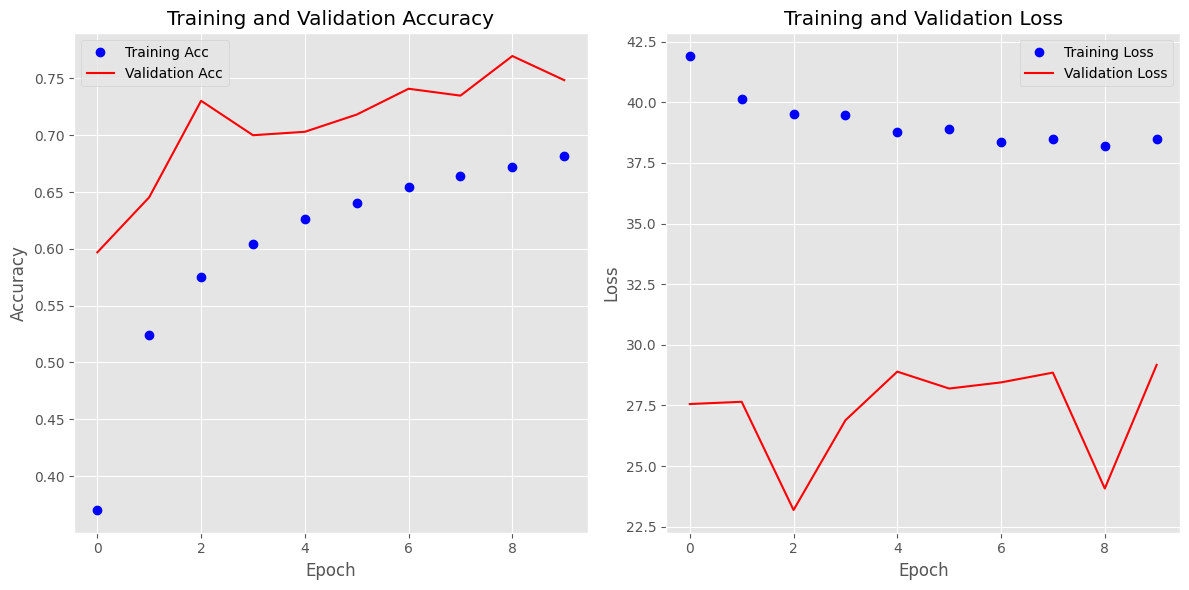

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0, len(acc))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First subplot for Accuracy
ax1.plot(epochs, acc, 'bo', label='Training Acc')
ax1.plot(epochs, val_acc, 'r', label='Validation Acc')
ax1.set_xlabel('Epoch')  # Setting x-axis label for the first subplot
ax1.set_ylabel('Accuracy')  # Setting y-axis label for the first subplot
ax1.set_title('Training and Validation Accuracy')
ax1.legend()

# Second subplot for Loss
ax2.plot(epochs, loss, 'bo', label='Training Loss')
ax2.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel("Epoch")
ax2.set_xlabel('Epoch')  # Setting x-axis label for the second subplot
ax2.set_ylabel('Loss')  # Setting y-axis label for the second subplot
ax2.set_title('Training and Validation Loss')
ax2.legend()

# Show the plots side by side
plt.tight_layout()
plt.show()

Evaluate the accuracy on the test set:

In [ ]:
model.evaluate(test_generator)

132/132 [==============================] - 7s 51ms/step - loss: 24.8744 - acc: 0.7661


[24.874387741088867, 0.7660952210426331]

## Fine-tuning: `IV3TRF`

- The last 12 layers will be fine tuned

Unfreeze the layers

In [ ]:
model.trainable = True

# Unfreeze last 12 layers
for layer in model.layers[:-12]:
    layer.trainable = False

Recompile the model with a **lower learning rate = 0.001**

In [ ]:
model.compile(loss = 'categorical_crossentropy'
             ,optimizer = optimizers.Adam(learning_rate = 0.001) #lower learning rate
             ,metrics = ['acc'])

Perform the fine tuning on 4 more epochs

In [ ]:
model_save_dir = 'path...'
checkpoint_file= '/{epoch:02d}-{val_loss:.2f}.keras'

checkpoint_filepath = model_save_dir + checkpoint_file

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [ ]:
## set the number of additional epochs for fine-tuning
initial_epochs = 10
fine_tune_epochs = initial_epochs + 3

# Refit the model
history_2 = model.fit(train_generator,
                       epochs = fine_tune_epochs,
                       validation_data = validation_generator,
                       validation_steps = int(0.25*len(validation_generator)),
                      callbacks=[model_checkpoint_callback],
                      initial_epoch = history.epoch[-1]) # Start the epoch where it left before


Epoch 10/13
4232/4232 [==============================] - 748s 176ms/step - loss: 23.2296 - acc: 0.7513 - val_loss: 14.4476 - val_acc: 0.8212
Epoch 11/13
4232/4232 [==============================] - 751s 177ms/step - loss: 20.9223 - acc: 0.7664 - val_loss: 15.5305 - val_acc: 0.8212
Epoch 12/13
4232/4232 [==============================] - 752s 178ms/step - loss: 20.0905 - acc: 0.7706 - val_loss: 15.6871 - val_acc: 0.8136
Epoch 13/13
4232/4232 [==============================] - 743s 176ms/step - loss: 19.2771 - acc: 0.7736 - val_loss: 14.3077 - val_acc: 0.8576


Save the results:

- `IV3TRF`

In [ ]:
model_save_dir = 'path...'
model_name= '/IV3TRF.keras'

model_filepath = model_save_dir + model_name

model.save(model_filepath)

Plotting the results:

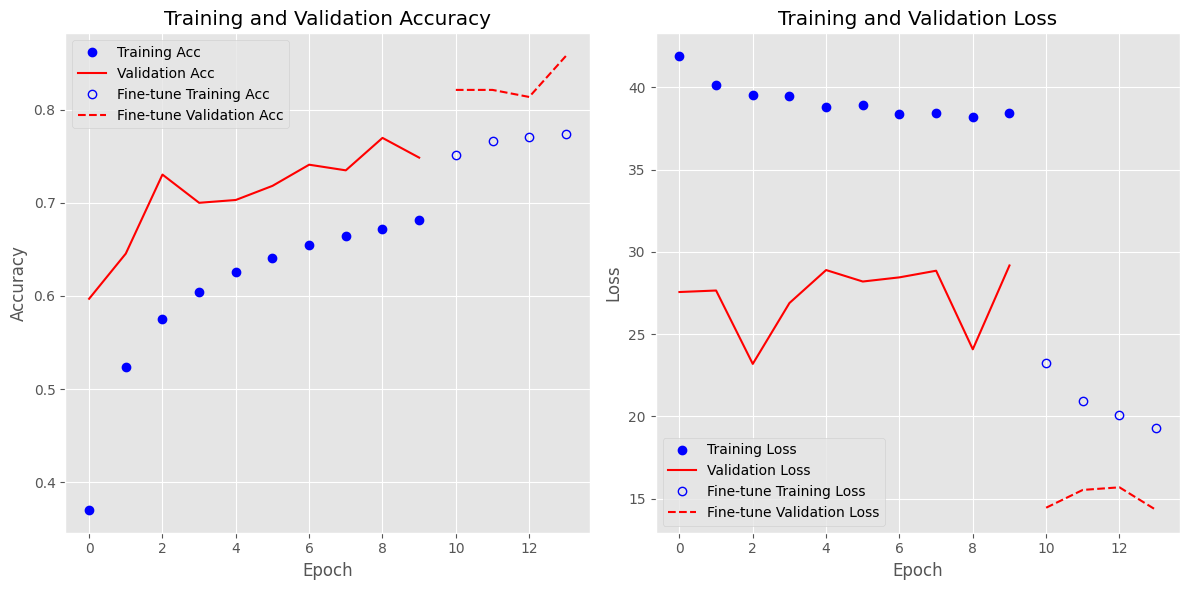

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# New fine-tuning history data
fine_tune_acc = history_2.history['acc']
fine_tune_val_acc = history_2.history['val_acc']
fine_tune_loss = history_2.history['loss']
fine_tune_val_loss = history_2.history['val_loss']

epochs = range(0, len(acc))

# Epochs for the fine-tuning (assuming fine-tuning started after the initial training)
fine_tune_epochs = range(len(acc), len(acc)+len(fine_tune_acc))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First subplot for Accuracy
ax1.plot(epochs, acc, 'bo', label='Training Acc')  # Full blue dots for initial training
ax1.plot(epochs, val_acc, 'r', label='Validation Acc')  # Solid red line for initial training
ax1.plot(fine_tune_epochs, fine_tune_acc, 'bo', fillstyle='none', label='Fine-tune Training Acc')  # Empty blue dots for fine-tuning
ax1.plot(fine_tune_epochs, fine_tune_val_acc, 'r--', label='Fine-tune Validation Acc')  # Red dashes for fine-tuning
ax1.set_xlabel('Epoch')  # Setting x-axis label for the first subplot
ax1.set_ylabel('Accuracy')  # Setting y-axis label for the first subplot
ax1.set_title('Training and Validation Accuracy')
ax1.legend()

# Second subplot for Loss
ax2.plot(epochs, loss, 'bo', label='Training Loss')  # Full blue dots for initial training
ax2.plot(epochs, val_loss, 'r', label='Validation Loss')  # Solid red line for initial training
ax2.plot(fine_tune_epochs, fine_tune_loss, 'bo', fillstyle='none', label='Fine-tune Training Loss')  # Empty blue dots for fine-tuning
ax2.plot(fine_tune_epochs, fine_tune_val_loss, 'r--', label='Fine-tune Validation Loss')  # Red dashes for fine-tuning
ax2.set_xlabel('Epoch')  # Setting x-axis label for the second subplot
ax2.set_ylabel('Loss')  # Setting y-axis label for the second subplot
ax2.set_title('Training and Validation Loss')
ax2.legend()

# Show the plots side by side
plt.tight_layout()
plt.show()

Evaluate on the test set

In [ ]:
model.evaluate(test_generator)

132/132 [==============================] - 5s 39ms/step - loss: 11.6073 - acc: 0.8552


[11.607332229614258, 0.8552380800247192]

( 0.8552380800247192-0.7660952210426331)*100

Through fine-tuning we have obtained a 8.9% improvement on the test set